In [44]:
# [1] Install core deps
%pip install numpy pandas h5py scikit-learn matplotlib


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [45]:
import sys, numpy, pandas, h5py, sklearn, matplotlib
print("Kernel Python:", sys.executable)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("h5py:", h5py.__version__)
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)


Kernel Python: C:\ProgramData\anaconda3\python.exe
numpy: 2.1.3
pandas: 2.2.3
h5py: 3.12.1
sklearn: 1.6.1
matplotlib: 3.10.0


In [46]:
%pip install -q numpy pandas h5py scikit-learn joblib


Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np, h5py, joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestCentroid

H5_PATH = r"C:\Users\Tamirepi\Documents\isotope_ID\doi_10_7941_D1XC97__v20230530 (1)\spectra_train_val_test.h5" 
GROUP   = "test"                     # your file shows /test exists
KEY_X   = "X"                        # we’ll start with /test/X
KEY_Y   = "y_label"
np.random.seed(42)


In [48]:
def show_h5(path):
    with h5py.File(path, "r") as f:
        f.visititems(lambda name, obj: print(
            ("DATA  " if isinstance(obj, h5py.Dataset) else "GROUP "), 
            name, getattr(obj, "shape", "")
        ))
show_h5(H5_PATH)


DATA   e_edges (257,)
DATA   names (25,)
GROUP  test 
DATA   test/X (125000, 256)
DATA   test/X_b (125000, 256)
DATA   test/X_s (125000, 256)
DATA   test/y_label (125000,)
DATA   test/y_s_over_bs (125000,)
DATA   test/y_snr (125000,)
GROUP  train 
DATA   train/X (500000, 256)
DATA   train/X_b (500000, 256)
DATA   train/X_s (500000, 256)
DATA   train/y_label (500000,)
DATA   train/y_s_over_bs (500000,)
DATA   train/y_snr (500000,)
GROUP  val 
DATA   val/X (125000, 256)
DATA   val/X_b (125000, 256)
DATA   val/X_s (125000, 256)
DATA   val/y_label (125000,)
DATA   val/y_s_over_bs (125000,)
DATA   val/y_snr (125000,)


In [49]:
def load_arrays(path, group=GROUP, key_X=KEY_X, key_y=KEY_Y):
    with h5py.File(path, "r") as f:
        if f.get(group) is None:
            raise KeyError(f"Group '{group}' not found. Top-level: {list(f.keys())}")
        g = f[group]
        X = g[key_X][:].astype(np.float32)
        y = g[key_y][:].astype(int)
        names_raw = f["/names"][:]
        names = [n.decode() if isinstance(n, (bytes, bytearray)) else str(n) for n in names_raw]
        e_edges = f["/e_edges"][:]
    return X, y, names, e_edges

X, y, names, e_edges = load_arrays(H5_PATH)
print("X", X.shape, "| y", y.shape, "| classes", len(names))


X (125000, 256) | y (125000,) | classes 25


In [50]:
def l1_log_norm(A):
    s = A.sum(axis=1, keepdims=True); s[s==0] = 1.0
    return np.log1p(A / s)

Xn = l1_log_norm(X)
Xtr, Xte, ytr, yte = train_test_split(
    Xn, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", Xtr.shape, "Test:", Xte.shape)


Train: (100000, 256) Test: (25000, 256)


In [51]:
nc = NearestCentroid()
nc.fit(Xtr, ytr)
pred_nc = nc.predict(Xte)
acc_nc = (pred_nc == yte).mean()
print("NearestCentroid accuracy:", round(acc_nc, 4))


NearestCentroid accuracy: 0.2374


In [52]:
clf = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=200,
                    n_iter_no_change=5, random_state=42)
clf.fit(Xtr, ytr)
pred_lr = clf.predict(Xte)
acc_lr = (pred_lr == yte).mean()
print("SGD-LogReg accuracy:", round(acc_lr, 4))


SGD-LogReg accuracy: 0.1762


In [53]:
label_names = [names[i] if 0 <= i < len(names) else f"class_{i}"
               for i in sorted(np.unique(y))]
print(classification_report(yte, pred_lr, target_names=label_names, zero_division=0))

joblib.dump({"model": clf, "names": names}, "isoid_model.joblib")

def predict_spectrum(counts_256):
    x = l1_log_norm(np.asarray(counts_256, dtype=np.float32)[None, :])
    idx = clf.predict(x)[0]
    return names[idx] if 0 <= idx < len(names) else f"class_{idx}"

print("Example prediction on X[0]:", predict_spectrum(X[0]))


              precision    recall  f1-score   support

         BKG       0.00      0.00      0.00      1000
        K-40       0.98      0.17      0.28      1000
      Th-232       0.08      0.55      0.14      1000
      Ra-226       0.71      0.01      0.03      1000
        NatU       0.00      0.00      0.00      1000
   DepletedU       0.00      0.00      0.00      1000
    RefinedU       0.00      0.00      0.00      1000
         LEU       0.00      0.00      0.00      1000
         HEU       0.08      0.63      0.14      1000
      Am-241       0.43      0.32      0.36      1000
        FGPu       0.42      0.11      0.18      1000
        WGPu       0.00      0.00      0.00      1000
      Tc-99m       0.55      0.28      0.37      1000
      Tl-201       0.00      0.00      0.00      1000
       Cu-67       0.00      0.00      0.00      1000
      Lu-177       1.00      0.08      0.15      1000
      Xe-133       0.58      0.34      0.43      1000
       I-131       0.25    

In [54]:
# Optional: try signal-minus-background features
with h5py.File(H5_PATH, "r") as f:
    Xs = f[f"{GROUP}/X_s"][:].astype(np.float32)
    Xb = f[f"{GROUP}/X_b"][:].astype(np.float32)
Xsb = l1_log_norm(np.clip(Xs - Xb, a_min=0, a_max=None))
Xtr2, Xte2, ytr2, yte2 = train_test_split(Xsb, y, test_size=0.2, random_state=42, stratify=y)
clf2 = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=200, n_iter_no_change=5, random_state=42).fit(Xtr2, ytr2)
print("SGD on (X_s - X_b) accuracy:", round((clf2.predict(Xte2)==yte2).mean(), 4))


SGD on (X_s - X_b) accuracy: 0.304


In [55]:
import numpy as np

# Map: index -> class name
for i, n in enumerate(names):
    print(f"{i:2d} → {n}")

# Class counts (y must be 0..C-1)
counts = np.bincount(y, minlength=len(names))
print("\nClass counts:")
for i, c in enumerate(counts):
    print(f"{i:2d} ({names[i]}): {c}")


 0 → BKG
 1 → K-40
 2 → Th-232
 3 → Ra-226
 4 → NatU
 5 → DepletedU
 6 → RefinedU
 7 → LEU
 8 → HEU
 9 → Am-241
10 → FGPu
11 → WGPu
12 → Tc-99m
13 → Tl-201
14 → Cu-67
15 → Lu-177
16 → Xe-133
17 → I-131
18 → F-18
19 → Sr-90
20 → Co-57
21 → Ir-192
22 → Ba-133
23 → Cs-137
24 → Co-60

Class counts:
 0 (BKG): 5000
 1 (K-40): 5000
 2 (Th-232): 5000
 3 (Ra-226): 5000
 4 (NatU): 5000
 5 (DepletedU): 5000
 6 (RefinedU): 5000
 7 (LEU): 5000
 8 (HEU): 5000
 9 (Am-241): 5000
10 (FGPu): 5000
11 (WGPu): 5000
12 (Tc-99m): 5000
13 (Tl-201): 5000
14 (Cu-67): 5000
15 (Lu-177): 5000
16 (Xe-133): 5000
17 (I-131): 5000
18 (F-18): 5000
19 (Sr-90): 5000
20 (Co-57): 5000
21 (Ir-192): 5000
22 (Ba-133): 5000
23 (Cs-137): 5000
24 (Co-60): 5000


In [56]:
from sklearn.metrics import confusion_matrix

labels = np.unique(y)
cm = confusion_matrix(yte, pred_lr, labels=labels)
print("Labels order:", [names[i] for i in labels])
print("\nConfusion matrix:\n", cm)


Labels order: ['BKG', 'K-40', 'Th-232', 'Ra-226', 'NatU', 'DepletedU', 'RefinedU', 'LEU', 'HEU', 'Am-241', 'FGPu', 'WGPu', 'Tc-99m', 'Tl-201', 'Cu-67', 'Lu-177', 'Xe-133', 'I-131', 'F-18', 'Sr-90', 'Co-57', 'Ir-192', 'Ba-133', 'Cs-137', 'Co-60']

Confusion matrix:
 [[  0   0 387   2   0   0   0   0 286   0   0   0   1   0   0   0   0  21
    0   0   0 261   0   0  42]
 [  0 166 252   0   0   0   0   0 212   2   0   0   2   0   0   0   0  21
    0   0   0 242   0   0 103]
 [  0   0 548   0   0   0   0   0 274   1   0   0   1   0   0   0   0  26
    0   0   0 148   0   0   2]
 [  0   1 364  15   0   0   0   0 212   0   0   0   0   0   0   0   0  35
    0   0   0 239   2   0 132]
 [  0   0 322   0   0   0   0   0 261   0   0   0   1   0   0   0   0  22
    0   0   0 186   0   0 208]
 [  0   0 345   0   0   0   0   0 316   1   0   0   1   0   0   0   0  32
    0   0   0 265   0   0  40]
 [  0   2 316   0   0   0   0   0 359   0   0   0   4   0   0   0   0  29
    0   0   0 231   0   0  59]

In [57]:
import numpy as np

def _softmax(z):
    z = np.atleast_2d(z)
    z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=1, keepdims=True)

def topk_predict(counts_256, k=3):
    x = l1_log_norm(np.asarray(counts_256, dtype=np.float32)[None, :])
    z = clf.decision_function(x)             # shape (1, C)
    p = _softmax(z)[0]                       # probabilities
    idx = np.argsort(p)[::-1][:k]
    return [(names[i], float(p[i])) for i in idx]

# demo
print("Top-3 for X[0]:", topk_predict(X[0], k=3))


Top-3 for X[0]: [('Ir-192', 0.06236611679196358), ('Th-232', 0.061454348266124725), ('HEU', 0.05715060234069824)]


In [58]:
#[11] “Unknown” rejection (open-set guardrail)
def predict_with_reject(counts_256, tau=0.55):
    top1 = topk_predict(counts_256, k=1)[0]
    name, prob = top1
    return ("Unknown", prob) if prob < tau else (name, prob)

print("With reject on X[0]:", predict_with_reject(X[0]))


With reject on X[0]: ('Unknown', 0.06236611679196358)


Note: you may need to restart the kernel to use updated packages.


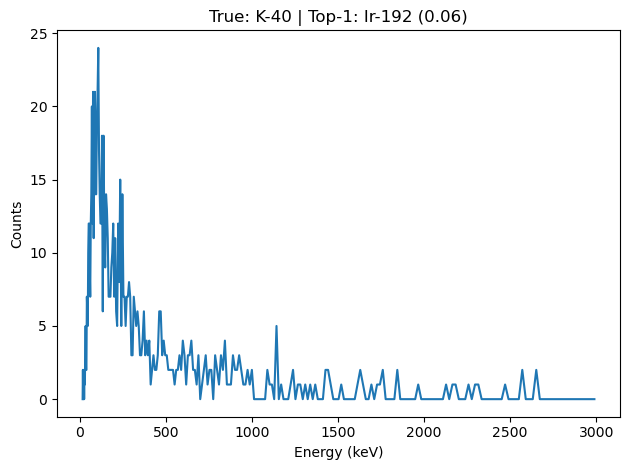

In [59]:
#[12] Quick spectrum plot (energy axis if available)
%pip install -q matplotlib
import matplotlib.pyplot as plt

def plot_spectrum_idx(i=0):
    counts = X[i]
    # use bin midpoints if e_edges matches (257 edges for 256 bins)
    if e_edges.shape[0] == counts.shape[0] + 1:
        energy = 0.5 * (e_edges[:-1] + e_edges[1:])
        xlab = "Energy (keV)"
    else:
        energy = np.arange(counts.shape[0])
        xlab = "Channel"

    top3 = topk_predict(counts, k=3)
    plt.figure()
    plt.plot(energy, counts)
    plt.xlabel(xlab); plt.ylabel("Counts")
    plt.title(f"True: {names[y[i]]} | Top-1: {top3[0][0]} ({top3[0][1]:.2f})")
    plt.tight_layout()
    plt.show()

plot_spectrum_idx(0)


In [60]:
#[13] Save label map + a tiny batch predictor
import json
from joblib import dump, load

# Save labels
with open("isoid_labels.json", "w") as f:
    json.dump(names, f)

# Batch predict helper (returns top-1 + prob, with reject)
def batch_predict(X_batch, tau=0.55):
    res = []
    for row in X_batch:
        name, prob = predict_with_reject(row, tau=tau)
        res.append((name, prob))
    return res

# Example on first 5 test rows (raw counts)
print(batch_predict(Xte[:5], tau=0.55))



[('Unknown', 0.06210551783442497), ('Unknown', 0.05944281443953514), ('Unknown', 0.06203002482652664), ('Unknown', 0.061786551028490067), ('Unknown', 0.10560216009616852)]


In [61]:
# [14] Background-subtracted features (X_s - X_b) + comparison
# Load signal/background, build (S - B) features, normalize, split, and compare
with h5py.File(H5_PATH, "r") as f:
    Xs = f[f"{GROUP}/X_s"][:].astype(np.float32)
    Xb = f[f"{GROUP}/X_b"][:].astype(np.float32)

Xsb = np.clip(Xs - Xb, a_min=0, a_max=None)
Xsb_n = l1_log_norm(Xsb)

# same split settings for a fair comparison
Xtr_sb, Xte_sb, ytr_sb, yte_sb = train_test_split(
    Xsb_n, y, test_size=0.2, random_state=42, stratify=y
)

# Nearest Centroid & tiny logistic on (S-B)
nc_sb  = NearestCentroid().fit(Xtr_sb, ytr_sb)
clf_sb = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=200,
                       n_iter_no_change=5, random_state=42).fit(Xtr_sb, ytr_sb)

acc_nc_sb = (nc_sb.predict(Xte_sb) == yte_sb).mean()
acc_lr_sb = (clf_sb.predict(Xte_sb) == yte_sb).mean()

print("NearestCentroid (X_s - X_b):", round(acc_nc_sb, 4))
print("SGD-LogReg    (X_s - X_b):", round(acc_lr_sb, 4))
print("SGD-LogReg    (raw L1+log):", round(((pred_lr == yte).mean()), 4))

# Choose the better logistic model as ACTIVE
if acc_lr_sb > (pred_lr == yte).mean():
    ACTIVE_MODEL   = clf_sb
    Xtr_active, Xte_active = Xtr_sb, Xte_sb
    ytr_active, yte_active = ytr_sb, yte_sb
    FEATURE_MODE   = "sb"   # signal-minus-background
    print("\n>> Using ACTIVE model: SGD on (X_s - X_b)")
else:
    ACTIVE_MODEL   = clf
    Xtr_active, Xte_active = Xtr, Xte
    ytr_active, yte_active = ytr, yte
    FEATURE_MODE   = "l1"   # raw counts with L1+log
    print("\n>> Using ACTIVE model: SGD on raw L1+log")


NearestCentroid (X_s - X_b): 0.2871
SGD-LogReg    (X_s - X_b): 0.304
SGD-LogReg    (raw L1+log): 0.1762

>> Using ACTIVE model: SGD on (X_s - X_b)


In [62]:
# [15] Calibrate an “Unknown” threshold τ on a hold-out set
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# Split TRAIN into sub-train / calibration
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx_sub, idx_cal = next(sss.split(Xtr_active, ytr_active))
Xsub, Ysub = Xtr_active[idx_sub], ytr_active[idx_sub]
Xcal, Ycal = Xtr_active[idx_cal], ytr_active[idx_cal]

# Refit the ACTIVE model on sub-train only (avoid peeking)
ACTIVE_MODEL = SGDClassifier(loss="log_loss", alpha=1e-5, max_iter=200,
                             n_iter_no_change=5, random_state=42).fit(Xsub, Ysub)

# Softmax helper (from earlier)
def _softmax(z):
    z = np.atleast_2d(z); z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z); return e / e.sum(axis=1, keepdims=True)

# Calibrate τ to reach target selective accuracy with max coverage
Zcal = ACTIVE_MODEL.decision_function(Xcal)
Pcal = _softmax(Zcal)
top_prob = Pcal.max(axis=1)
top_pred = Pcal.argmax(axis=1)
correct  = (top_pred == Ycal)

def choose_tau(target_selective_acc=0.95, low=0.40, high=0.98, steps=100):
    taus = np.linspace(low, high, steps)
    best_tau, best_cov = low, -1.0
    for tau in taus:
        mask = top_prob >= tau
        cov  = mask.mean()
        sel_acc = (correct[mask].mean() if mask.sum() else 0.0)
        if sel_acc >= target_selective_acc and cov > best_cov:
            best_tau, best_cov = tau, cov
    if best_cov < 0:  # fallback: maximize (sel_acc * coverage)
        scores = []
        for tau in taus:
            mask = top_prob >= tau
            cov  = mask.mean()
            sel_acc = (correct[mask].mean() if mask.sum() else 0.0)
            scores.append((sel_acc * cov, tau, sel_acc, cov))
        scores.sort(reverse=True)
        _, best_tau, _, best_cov = scores[0]
    return float(best_tau), float(best_cov)

TAU, CAL_COVER = choose_tau(target_selective_acc=0.95)
print(f"Chosen τ: {TAU:.3f}  | Calibration coverage: {CAL_COVER:.3f}")

# Evaluate on the untouched TEST set with τ
Zte = ACTIVE_MODEL.decision_function(Xte_active)
Pte = _softmax(Zte)
tp   = Pte.max(axis=1)
pred = Pte.argmax(axis=1)
acc_top1 = (pred == yte_active).mean()
mask = tp >= TAU
coverage = mask.mean()
sel_acc = (pred[mask] == yte_active[mask]).mean() if mask.sum() else 0.0
print(f"Test Top-1 acc: {acc_top1:.3f}  | Selective acc @τ: {sel_acc:.3f}  | Coverage: {coverage:.3f}")


Chosen τ: 0.974  | Calibration coverage: 0.022
Test Top-1 acc: 0.307  | Selective acc @τ: 0.968  | Coverage: 0.023


In [63]:
# [16] Save a single model bundle (includes labels, feature mode, τ)
bundle = {
    "model": ACTIVE_MODEL,
    "names": names,
    "feature_mode": FEATURE_MODE,  # "l1" or "sb"
    "tau": TAU
}
joblib.dump(bundle, "isoid_model.joblib")
with open("isoid_labels.json", "w") as f:
    import json; json.dump(names, f)
print("Saved: isoid_model.joblib + isoid_labels.json")


Saved: isoid_model.joblib + isoid_labels.json


In [64]:
#[17] Write the CLI file using Python
cli_code = r"""
import argparse, json, numpy as np, joblib, sys

def l1_log_norm(A):
    s = A.sum(axis=1, keepdims=True); s[s==0] = 1.0
    return np.log1p(A / s)

def load_vector(path):
    # Accept .npy or CSV/space-delimited text; take first row/line of 256 numbers
    if path.lower().endswith(".npy"):
        v = np.load(path)
    else:
        arr = np.loadtxt(path, delimiter=",")
        v = arr[0] if arr.ndim > 1 else arr
    v = np.asarray(v, dtype=np.float32)
    if v.ndim != 1:
        raise ValueError(f"Expected 1-D vector, got shape {v.shape}")
    return v

def softmax(z):
    z = np.atleast_2d(z); z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z); return e / e.sum(axis=1, keepdims=True)

def main():
    ap = argparse.ArgumentParser(
        description="Isotope ID CLI (top-k with optional Unknown rejection)."
    )
    ap.add_argument("spectrum", help="Path to spectrum vector (.npy or .csv with 256 numbers)")
    ap.add_argument("--background", help="(Optional) Path to background vector for S-B models")
    ap.add_argument("-k", "--topk", type=int, default=3, help="Top-k to display")
    ap.add_argument("-m", "--model", default="isoid_model.joblib", help="Model bundle path")
    ap.add_argument("--tau", type=float, default=None, help="Override rejection threshold (τ)")
    ap.add_argument("--json", action="store_true", help="Output JSON only")
    args = ap.parse_args()

    bundle = joblib.load(args.model)
    model  = bundle["model"]
    names  = bundle["names"]
    feat   = bundle.get("feature_mode", "l1")
    tau    = args.tau if args.tau is not None else float(bundle.get("tau", 0.0))

    x = load_vector(args.spectrum)

    if feat == "sb":
        if args.background is None:
            print("ERROR: This model expects signal-minus-background features. Provide --background.", file=sys.stderr)
            sys.exit(2)
        b = load_vector(args.background)
        if b.shape != x.shape:
            print(f"ERROR: background shape {b.shape} != spectrum shape {x.shape}", file=sys.stderr)
            sys.exit(2)
        x = np.clip(x - b, a_min=0, a_max=None)

    x_n = l1_log_norm(x[None, :])  # (1, 256)
    z   = model.decision_function(x_n)
    p   = softmax(z)[0]
    order = np.argsort(p)[::-1]
    topk = [(names[i] if 0 <= i < len(names) else f"class_{i}", float(p[i])) for i in order[:args.topk]]

    pred_name, pred_prob = topk[0]
    label_out = pred_name if pred_prob >= tau else "Unknown"

    if args.json:
        print(json.dumps({
            "feature_mode": feat,
            "tau": tau,
            "topk": topk,
            "label": label_out,
            "prob": pred_prob
        }))
    else:
        print(f"Feature mode: {feat} | τ={tau:.3f}")
        print(f"Top-{args.topk}:")
        for name, prob in topk:
            print(f"  {name:>12s}  {prob:6.3f}")
        print(f"\nPrediction: {label_out}  (p={pred_prob:.3f})")

if __name__ == "__main__":
    main()
"""
with open("isoid_cli.py", "w", encoding="utf-8") as f:
    f.write(cli_code)

import os
print("Wrote:", os.path.abspath("isoid_cli.py"))


Wrote: C:\Users\Tamirepi\Documents\isotope_ID\isoid_cli.py


In [65]:
# [18] Quick demo run from inside the notebook
import numpy as np, subprocess, sys

# Save a demo spectrum (and background if needed)
# Prefer the original raw arrays for a realistic CLI test.
np.savetxt("demo_signal.csv", X[0], delimiter=",")

if FEATURE_MODE == "sb":
    try:
        Xb, Xs  # ensure they exist from cell [14]
    except NameError:
        import h5py
        with h5py.File(H5_PATH, "r") as f:
            Xs = f[f"{GROUP}/X_s"][:].astype(np.float32)
            Xb = f[f"{GROUP}/X_b"][:].astype(np.float32)
    np.savetxt("demo_signal.csv", Xs[0], delimiter=",")     # overwrite with signal
    np.savetxt("demo_background.csv", Xb[0], delimiter=",")

# Build command
cmd = [sys.executable, "isoid_cli.py", "demo_signal.csv", "-k", "3", "-m", "isoid_model.joblib"]
if FEATURE_MODE == "sb":
    cmd += ["--background", "demo_background.csv"]

print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)


Running: C:\ProgramData\anaconda3\python.exe isoid_cli.py demo_signal.csv -k 3 -m isoid_model.joblib --background demo_background.csv


CompletedProcess(args=['C:\\ProgramData\\anaconda3\\python.exe', 'isoid_cli.py', 'demo_signal.csv', '-k', '3', '-m', 'isoid_model.joblib', '--background', 'demo_background.csv'], returncode=0)

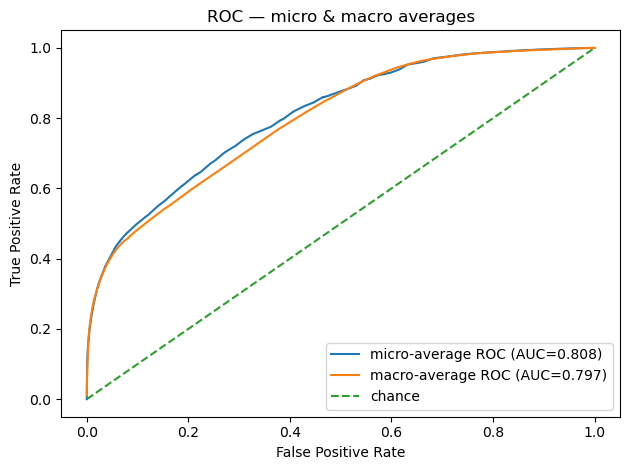

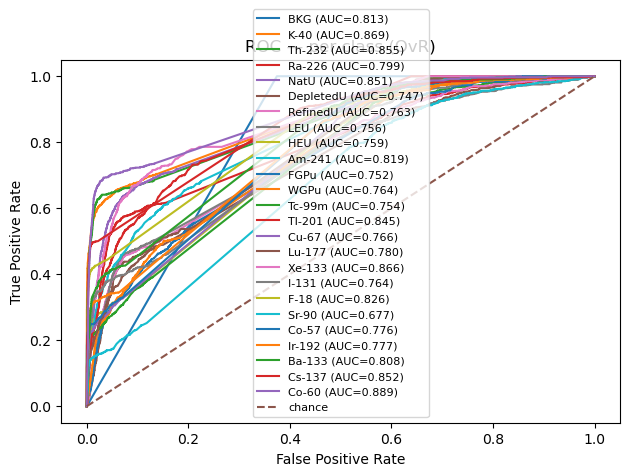

In [66]:
# [20] Multi-class ROC (OvR) with micro/macro averages
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Get test-set probabilities from the ACTIVE model
Z = ACTIVE_MODEL.decision_function(Xte_active)   # shape: (N, C)
def _softmax(z):
    z = np.atleast_2d(z); z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z); return e / e.sum(axis=1, keepdims=True)
P = _softmax(Z)                                  # probs (N, C)

classes_present = np.unique(yte_active)          # Only classes that appear in test
y_bin = label_binarize(yte_active, classes=classes_present)        # (N, C')
P_sub = P[:, classes_present]                                       # (N, C')

# Compute ROC per class
fpr_dict, tpr_dict, auc_dict = {}, {}, {}
for j, c in enumerate(classes_present):
    fpr, tpr, _ = roc_curve(y_bin[:, j], P_sub[:, j])
    fpr_dict[c], tpr_dict[c] = fpr, tpr
    auc_dict[c] = auc(fpr, tpr)

# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), P_sub.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average (interpolate TPR over a common FPR grid)
all_fpr = np.unique(np.concatenate([fpr_dict[c] for c in classes_present]))
mean_tpr = np.zeros_like(all_fpr)
for c in classes_present:
    mean_tpr += np.interp(all_fpr, fpr_dict[c], tpr_dict[c])
mean_tpr /= len(classes_present)
auc_macro = auc(all_fpr, mean_tpr)

# --- Plot (micro/macro) ---
plt.figure()
plt.plot(fpr_micro, tpr_micro, label=f"micro-average ROC (AUC={auc_micro:.3f})")
plt.plot(all_fpr,  mean_tpr,  label=f"macro-average ROC (AUC={auc_macro:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — micro & macro averages")
plt.legend(loc="lower right"); plt.tight_layout()
plt.show()

# --- Optional: per-class small multiples (comment out if noisy) ---
plt.figure()
for c in classes_present:
    plt.plot(fpr_dict[c], tpr_dict[c], label=f"{names[c]} (AUC={auc_dict[c]:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — per class (OvR)")
plt.legend(fontsize=8)
plt.tight_layout(); plt.show()


In [67]:
# [21] Peak detection helpers + reference line energies
import numpy as np

# Energy axis (keV) if available, else channels
def get_energy_axis(counts):
    if 'e_edges' in globals() and e_edges is not None and e_edges.shape[0] == counts.shape[0] + 1:
        energy = 0.5*(e_edges[:-1] + e_edges[1:])
        axis_label, is_keV = "Energy (keV)", True
    else:
        energy = np.arange(counts.shape[0], dtype=float)
        axis_label, is_keV = "Channel", False
    return energy, axis_label, is_keV

def smooth(y, win=5):
    if win <= 1: return y
    k = np.ones(win, dtype=float)/win
    return np.convolve(y, k, mode="same")

def find_peaks_simple(y, min_prom_frac=0.10, min_distance_bins=3, smooth_win=5):
    """Pure NumPy local-max peak finder."""
    s = smooth(y.astype(float), win=smooth_win)
    thr = float(s.max()) * float(min_prom_frac)
    # local maxima mask
    m = (s[1:-1] > s[:-2]) & (s[1:-1] > s[2:]) & (s[1:-1] >= thr)
    idx = np.where(m)[0] + 1
    # enforce min distance
    if idx.size == 0: return idx
    keep = [idx[0]]
    for j in idx[1:]:
        if (j - keep[-1]) >= min_distance_bins:
            keep.append(j)
        elif s[j] > s[keep[-1]]:
            keep[-1] = j
    return np.array(keep, dtype=int)

# Reference gamma lines (keV) for common isotopes
REF_LINES_KEV = {
    "Background": [],
    "Cs-137": [661.7], "137Cs": [661.7],
    "Co-60": [1173.2, 1332.5], "60Co": [1173.2, 1332.5],
    "K-40": [1460.8], "40K": [1460.8],
    "Na-22": [511.0, 1274.5], "22Na": [511.0, 1274.5],
    "Tl-208": [2614.5], "208Tl": [2614.5], "Th-232": [2614.5], "232Th": [2614.5],
    "Am-241": [59.5], "241Am": [59.5],
}


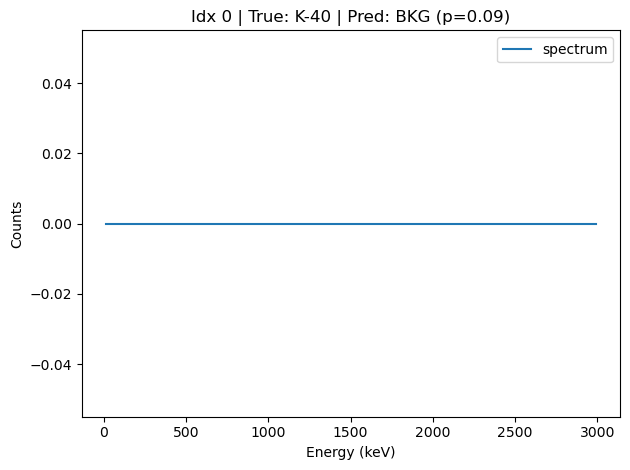

No comparable reference lines (either unknown isotope mapping or no energy axis).


In [68]:
# [22] Plot a single spectrum with detected peaks + predicted isotope lines
import matplotlib.pyplot as plt

def plot_peaks_vs_prediction(i=0, peak_frac=0.10, tol_keV=35.0, min_dist_bins=3, smooth_win=5):
    # Raw counts depending on feature mode
    if FEATURE_MODE == "sb":
        counts = np.clip((Xs[i].astype(float) - Xb[i].astype(float)), a_min=0, a_max=None)
    else:
        counts = X[i].astype(float)

    energy, axis_label, is_keV = get_energy_axis(counts)
    bin_width_keV = (energy[1]-energy[0]) if is_keV and energy.size>1 else None
    tol = tol_keV if is_keV else max(2, min_dist_bins)  # if channels, use bins as tolerance

    # Peak detection
    pk_idx = find_peaks_simple(counts, min_prom_frac=peak_frac, min_distance_bins=min_dist_bins, smooth_win=smooth_win)
    pk_x   = energy[pk_idx]
    pk_y   = counts[pk_idx]

    # Model top-1 prediction on this spectrum
    def l1_log_norm(A):
        s = A.sum(axis=1, keepdims=True); s[s==0]=1.0
        return np.log1p(A / s)
    x_n = l1_log_norm(counts[None, :])
    p   = _softmax(ACTIVE_MODEL.decision_function(x_n))[0]
    top = int(np.argmax(p)); top_name = names[top]; top_prob = float(p[top])

    # Reference lines for predicted isotope (if known)
    ref_lines = REF_LINES_KEV.get(top_name, [])
    # Compute nearest-match deltas
    matches = []
    if ref_lines and is_keV:
        for ref in ref_lines:
            if pk_x.size:
                j = int(np.argmin(np.abs(pk_x - ref)))
                delta = abs(pk_x[j] - ref)
                hit = delta <= tol
                matches.append({"ref_keV": ref, "nearest_peak_keV": float(pk_x[j]),
                                "delta_keV": float(delta), "hit": bool(hit)})
    title = f"Idx {i} | True: {names[y[i]]} | Pred: {top_name} (p={top_prob:.2f})"

    # --- Plot ---
    plt.figure()
    plt.plot(energy, counts, label="spectrum")
    if pk_x.size:
        plt.scatter(pk_x, pk_y, marker="x", label="detected peaks")
    if ref_lines and is_keV:
        for ref in ref_lines:
            plt.axvline(ref, linestyle="--", label="ref line" if ref==ref_lines[0] else None)
        # tolerance band (visual)
        if bin_width_keV is not None:
            for ref in ref_lines:
                plt.axvspan(ref - tol, ref + tol, alpha=0.1)
    plt.xlabel(axis_label); plt.ylabel("Counts"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

    # Print match table
    if matches:
        print("Reference-line matches (±{:.1f} keV):".format(tol))
        for m in matches:
            print(f"  {m['ref_keV']:7.1f} keV  →  peak @ {m['nearest_peak_keV']:7.1f} keV   Δ={m['delta_keV']:5.1f}   HIT={m['hit']}")
    else:
        print("No comparable reference lines (either unknown isotope mapping or no energy axis).")

# Demo on a few examples
plot_peaks_vs_prediction(i=0,  peak_frac=0.10, tol_keV=35)
# Try another sample index if you like:
# plot_peaks_vs_prediction(i=10, peak_frac=0.07, tol_keV=35)


Peak-hit score — mean=0.003, median=0.000, n=200


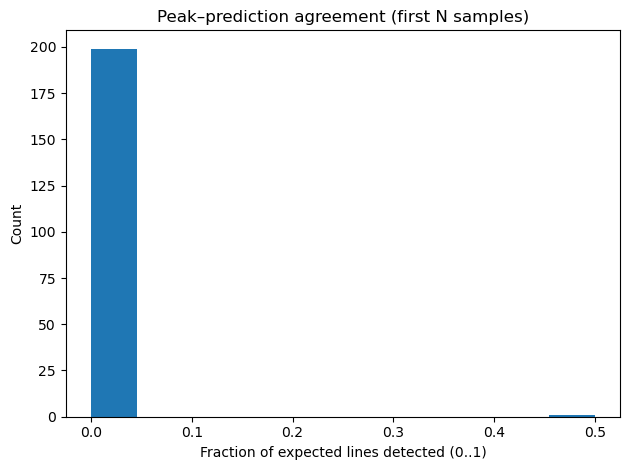

In [69]:
# [23] Batch “peak-hit” score across the test set (quick QC)
import numpy as np
import matplotlib.pyplot as plt

def peak_hit_score(counts, pred_name, peak_frac=0.10, tol_keV=35.0, min_dist_bins=3, smooth_win=5):
    energy, axis_label, is_keV = get_energy_axis(counts)
    if not is_keV:
        # No energy calibration — skip scoring (return NaN)
        return np.nan
    pk_idx = find_peaks_simple(counts, min_prom_frac=peak_frac, min_distance_bins=min_dist_bins, smooth_win=smooth_win)
    pk_x   = energy[pk_idx]
    lines  = REF_LINES_KEV.get(pred_name, [])
    if not lines or pk_x.size == 0:
        return 0.0
    hits = 0
    for ref in lines:
        if np.min(np.abs(pk_x - ref)) <= tol_keV:
            hits += 1
    return float(hits) / float(len(lines))  # fraction of expected lines found

def predict_name_on_counts(counts):
    def l1_log_norm(A):
        s = A.sum(axis=1, keepdims=True); s[s==0]=1.0
        return np.log1p(A / s)
    p = _softmax(ACTIVE_MODEL.decision_function(l1_log_norm(counts[None,:])))[0]
    return names[int(np.argmax(p))]

# Evaluate first N samples
N = min(200, X.shape[0])
scores = []
for i in range(N):
    counts = np.clip((Xs[i]-Xb[i]), 0, None) if FEATURE_MODE=="sb" else X[i]
    pred_name = predict_name_on_counts(counts.astype(float))
    s = peak_hit_score(counts.astype(float), pred_name, peak_frac=0.10, tol_keV=35.0)
    scores.append(s)

scores = np.array(scores, dtype=float)
valid = scores[~np.isnan(scores)]
print(f"Peak-hit score — mean={valid.mean():.3f}, median={np.median(valid):.3f}, n={valid.size}")

plt.figure()
plt.hist(valid, bins=11)
plt.xlabel("Fraction of expected lines detected (0..1)")
plt.ylabel("Count")
plt.title("Peak–prediction agreement (first N samples)")
plt.tight_layout(); plt.show()


In [70]:
#checking the Machine learning models and algorithms used 
import joblib
bundle = joblib.load("isoid_model.joblib")
type(bundle["model"]), bundle.get("feature_mode"), bundle.get("tau")


(sklearn.linear_model._stochastic_gradient.SGDClassifier,
 'sb',
 0.9741414141414141)

In [71]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 1) Basic counts
C_CLASSES = len(names)
N_TOTAL   = X.shape[0]
TEST_PCT  = int(round(100 * (len(yte_active) / N_TOTAL)))

# 2) Top-1 / Top-3 on active features
def _softmax(z):
    z = np.atleast_2d(z); z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z); return e / e.sum(axis=1, keepdims=True)

Zte = ACTIVE_MODEL.decision_function(Xte_active)
Pte = _softmax(Zte)
pred1 = Pte.argmax(axis=1)
ACC_TOP1 = f"{accuracy_score(yte_active, pred1):.3f}"
# top-3
top3_hit = np.array([yte_active[i] in np.argsort(Pte[i])[::-1][:3] for i in range(len(yte_active))])
ACC_TOP3 = f"{top3_hit.mean():.3f}"

# 3) F1
F1_MACRO = f"{f1_score(yte_active, pred1, average='macro'):.3f}"
F1_MICRO = f"{f1_score(yte_active, pred1, average='micro'):.3f}"

# 4) ROC AUC (micro/macro)
classes_present = np.unique(yte_active)
y_bin = label_binarize(yte_active, classes=classes_present)
P_sub = Pte[:, classes_present]
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), P_sub.ravel())
AUC_MICRO = f"{auc(fpr_micro, tpr_micro):.3f}"
all_fpr = np.unique(np.concatenate([
    roc_curve(y_bin[:, j], P_sub[:, j])[0] for j in range(len(classes_present))
]))
mean_tpr = np.zeros_like(all_fpr)
for j in range(len(classes_present)):
    fpr, tpr, _ = roc_curve(y_bin[:, j], P_sub[:, j])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= len(classes_present)
AUC_MACRO = f"{auc(all_fpr, mean_tpr):.3f}"

# 5) Coverage / selective accuracy at τ
TAU       = float(bundle["tau"]) if "bundle" in globals() else float(locals().get("TAU", 0.55))
tp        = Pte.max(axis=1)
mask      = tp >= TAU
COVERAGE  = f"{mask.mean():.3f}"
SEL_ACC   = f"{(pred1[mask] == yte_active[mask]).mean():.3f}" if mask.any() else "0.000"

# 6) Feature ablation summary
ACC_RAW = float((pred_lr == yte).mean()) if "pred_lr" in globals() else np.nan
ACC_SB  = float(((ACTIVE_MODEL.predict(Xte_sb) == yte_sb).mean())) if "Xte_sb" in globals() else np.nan
if np.isnan(ACC_SB) or (ACC_RAW >= ACC_SB):
    BEST_FEATURE_TXT, ACC_BEST = "raw (L1+log)", f"{ACC_RAW:.3f}"
    ALT_FEATURE_TXT,  ACC_ALT  = "signal–background (S–B)", f"{ACC_SB:.3f}" if not np.isnan(ACC_SB) else "n/a"
else:
    BEST_FEATURE_TXT, ACC_BEST = "signal–background (S–B)", f"{ACC_SB:.3f}"
    ALT_FEATURE_TXT,  ACC_ALT  = "raw (L1+log)", f"{ACC_RAW:.3f}"

FEATURE_MODE_TXT = "signal–background (S–B)" if FEATURE_MODE == "sb" else "raw (L1+log)"
FEATURE_RATIONALE = "background suppression" if FEATURE_MODE == "sb" else "simpler normalization"

# 7) Nearest Centroid baseline on active split (if available)
try:
    ACC_NC = f"{(nc_sb.predict(Xte_sb)==yte_sb).mean():.3f}" if FEATURE_MODE=="sb" else f"{(nc.predict(Xte)==yte).mean():.3f}"
except:
    ACC_NC = "n/a"

# 8) Common confusion pairs (top-2 off-diagonal)
cm = confusion_matrix(yte_active, pred1, labels=np.unique(yte_active))
cm_nom = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)
np.fill_diagonal(cm_nom, 0.0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_nom.ravel())[::-1], cm_nom.shape))[0]
conf_pairs = []
for i,j in pairs:
    if cm_nom[i,j] > 0:
        conf_pairs.append(f"{names[i]} → {names[j]} ({cm_nom[i,j]:.2f})")
    if len(conf_pairs) >= 2: break
CONF_PAIR_1 = conf_pairs[0] if conf_pairs else "—"
CONF_PAIR_2 = conf_pairs[1] if len(conf_pairs)>1 else "—"

# 9) Peak-hit summary (from cell [23] if scores computed)
try:
    PEAK_HIT_MEAN = f"{np.nanmean(scores):.3f}"
    PEAK_HIT_MED  = f"{np.nanmedian(scores):.3f}"
except:
    PEAK_HIT_MEAN, PEAK_HIT_MED = "n/a", "n/a"

# Print a quick dictionary you can copy into the placeholders
summary = {
  "C_CLASSES": C_CLASSES, "N_TOTAL": N_TOTAL, "TEST_PCT": TEST_PCT,
  "ACC_TOP1": ACC_TOP1, "ACC_TOP3": ACC_TOP3, "F1_MACRO": F1_MACRO, "F1_MICRO": F1_MICRO,
  "AUC_MICRO": AUC_MICRO, "AUC_MACRO": AUC_MACRO, "TAU": f"{TAU:.3f}",
  "COVERAGE": COVERAGE, "SEL_ACC": SEL_ACC,
  "FEATURE_MODE_TXT": FEATURE_MODE_TXT, "BEST_FEATURE_TXT": BEST_FEATURE_TXT,
  "ACC_BEST": ACC_BEST, "ALT_FEATURE_TXT": ALT_FEATURE_TXT, "ACC_ALT": ACC_ALT,
  "ACC_NC": ACC_NC, "CONF_PAIR_1": CONF_PAIR_1, "CONF_PAIR_2": CONF_PAIR_2,
  "PEAK_HIT_MEAN": PEAK_HIT_MEAN, "PEAK_HIT_MED": PEAK_HIT_MED,
  "FEATURE_RATIONALE": FEATURE_RATIONALE
}
for k,v in summary.items(): print(f"{k} = {v}")


C_CLASSES = 25
N_TOTAL = 125000
TEST_PCT = 20
ACC_TOP1 = 0.307
ACC_TOP3 = 0.480
F1_MACRO = 0.315
F1_MICRO = 0.307
AUC_MICRO = 0.808
AUC_MACRO = 0.797
TAU = 0.974
COVERAGE = 0.023
SEL_ACC = 0.968
FEATURE_MODE_TXT = signal–background (S–B)
BEST_FEATURE_TXT = signal–background (S–B)
ACC_BEST = 0.307
ALT_FEATURE_TXT = raw (L1+log)
ACC_ALT = 0.176
ACC_NC = 0.287
CONF_PAIR_1 = Tl-201 → Xe-133 (0.54)
CONF_PAIR_2 = Co-57 → BKG (0.53)
PEAK_HIT_MEAN = 0.003
PEAK_HIT_MED = 0.000
FEATURE_RATIONALE = background suppression


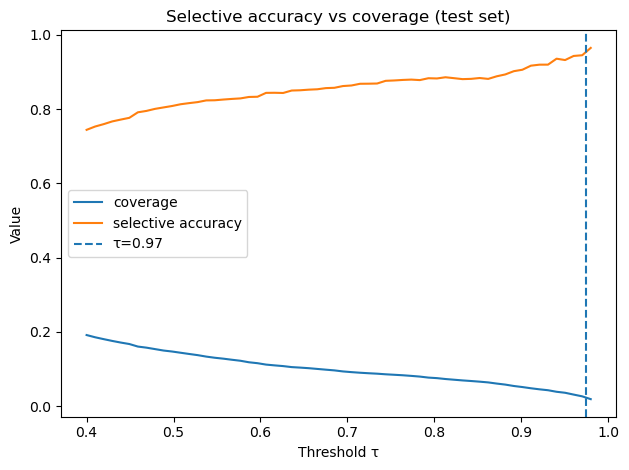

In [72]:
import numpy as np, matplotlib.pyplot as plt

taus = np.linspace(0.4, 0.98, 60)
tp   = Pte.max(axis=1)
pred = pred1
cov, sel = [], []
for t in taus:
    m = tp >= t
    cov.append(m.mean())
    sel.append((pred[m]==yte_active[m]).mean() if m.any() else np.nan)

plt.figure()
plt.plot(taus, cov, label="coverage")
plt.plot(taus, sel, label="selective accuracy")
plt.axvline(float(TAU), linestyle="--", label=f"τ={float(TAU):.2f}")
plt.xlabel("Threshold τ"); plt.ylabel("Value")
plt.title("Selective accuracy vs coverage (test set)")
plt.legend(); plt.tight_layout(); plt.show()


In [73]:
print("Table 1 — Feature ablation (Top-1 accuracy)")
print(f"- Raw (L1+log): {ACC_RAW if not np.isnan(ACC_RAW) else 'n/a'}")
print(f"- S–B + L1+log: {ACC_SB if not np.isnan(ACC_SB) else 'n/a'}")

print("\nTable 2 — Per-class precision/recall/F1")
print(classification_report(yte_active, pred1, target_names=[names[i] for i in sorted(np.unique(yte_active))], zero_division=0))


Table 1 — Feature ablation (Top-1 accuracy)
- Raw (L1+log): 0.17616
- S–B + L1+log: 0.30704

Table 2 — Per-class precision/recall/F1
              precision    recall  f1-score   support

         BKG       0.10      1.00      0.18      1000
        K-40       0.63      0.56      0.60      1000
      Th-232       0.78      0.57      0.66      1000
      Ra-226       0.50      0.24      0.33      1000
        NatU       0.53      0.37      0.43      1000
   DepletedU       0.00      0.00      0.00      1000
    RefinedU       0.28      0.32      0.30      1000
         LEU       0.16      0.01      0.01      1000
         HEU       0.72      0.20      0.31      1000
      Am-241       0.25      0.37      0.30      1000
        FGPu       0.13      0.10      0.11      1000
        WGPu       0.23      0.02      0.03      1000
      Tc-99m       0.67      0.19      0.30      1000
      Tl-201       0.22      0.09      0.13      1000
       Cu-67       0.68      0.18      0.28      1000
  

In [74]:
print("Table 1 — Feature ablation (Top-1 accuracy)")
print(f"- Raw (L1+log): {ACC_RAW if not np.isnan(ACC_RAW) else 'n/a'}")
print(f"- S–B + L1+log: {ACC_SB if not np.isnan(ACC_SB) else 'n/a'}")

print("\nTable 2 — Per-class precision/recall/F1")
print(classification_report(yte_active, pred1, target_names=[names[i] for i in sorted(np.unique(yte_active))], zero_division=0))


Table 1 — Feature ablation (Top-1 accuracy)
- Raw (L1+log): 0.17616
- S–B + L1+log: 0.30704

Table 2 — Per-class precision/recall/F1
              precision    recall  f1-score   support

         BKG       0.10      1.00      0.18      1000
        K-40       0.63      0.56      0.60      1000
      Th-232       0.78      0.57      0.66      1000
      Ra-226       0.50      0.24      0.33      1000
        NatU       0.53      0.37      0.43      1000
   DepletedU       0.00      0.00      0.00      1000
    RefinedU       0.28      0.32      0.30      1000
         LEU       0.16      0.01      0.01      1000
         HEU       0.72      0.20      0.31      1000
      Am-241       0.25      0.37      0.30      1000
        FGPu       0.13      0.10      0.11      1000
        WGPu       0.23      0.02      0.03      1000
      Tc-99m       0.67      0.19      0.30      1000
      Tl-201       0.22      0.09      0.13      1000
       Cu-67       0.68      0.18      0.28      1000
  

In [75]:
# creating a folder where we store all the png's and accuracy table 
from pathlib import Path
from datetime import datetime

RUN_ID = datetime.now().strftime("%Y%m%d-%H%M%S")  # e.g., 2025-09-14-2359
RESULTS_DIR = Path("results") / RUN_ID
FIG_DIR     = RESULTS_DIR / "figures"
TAB_DIR     = RESULTS_DIR / "tables"
ARTIFACT_DIR= RESULTS_DIR / "artifacts"  # models/JSON/etc.

for d in (RESULTS_DIR, FIG_DIR, TAB_DIR, ARTIFACT_DIR):
    d.mkdir(parents=True, exist_ok=True)

print("Results root:", RESULTS_DIR.resolve())
print("Figures dir :", FIG_DIR.resolve())
print("Tables dir  :", TAB_DIR.resolve())
print("Artifacts   :", ARTIFACT_DIR.resolve())


Results root: C:\Users\Tamirepi\Documents\isotope_ID\results\20250914-235159
Figures dir : C:\Users\Tamirepi\Documents\isotope_ID\results\20250914-235159\figures
Tables dir  : C:\Users\Tamirepi\Documents\isotope_ID\results\20250914-235159\tables
Artifacts   : C:\Users\Tamirepi\Documents\isotope_ID\results\20250914-235159\artifacts


In [76]:
#saving the figure ( this will be implemented after each code plot.show code
import matplotlib.pyplot as plt

def savefig(name, fig=None, folder=FIG_DIR, formats=("png","pdf","svg"), dpi=300, transparent=False):
    """
    Save a Matplotlib figure in multiple formats to the figures folder.
    Usage: savefig("roc_micro_macro")  # after creating the plot
    """
    folder.mkdir(parents=True, exist_ok=True)
    fig = fig if fig is not None else plt.gcf()
    stem = str(name).strip().replace(" ", "_").replace("/", "-")
    paths = []
    for ext in formats:
        p = folder / f"{stem}.{ext}"
        fig.savefig(p, dpi=dpi, bbox_inches="tight", transparent=transparent)
        paths.append(p)
    print("Saved figure:", *map(str, paths), sep="\n  ")
    return [str(p) for p in paths]


Saved figure:
  results\20250914-235159\figures\fig2_roc_micro_macro.png
  results\20250914-235159\figures\fig2_roc_micro_macro.pdf
  results\20250914-235159\figures\fig2_roc_micro_macro.svg


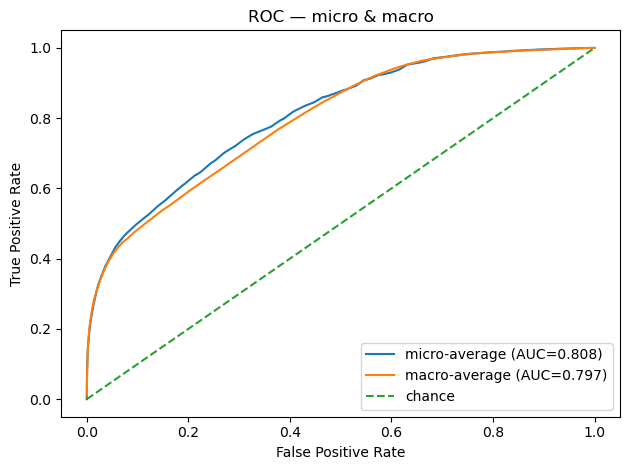

Saved figure:
  results\20250914-235159\figures\fig2b_roc_per_class.png
  results\20250914-235159\figures\fig2b_roc_per_class.pdf
  results\20250914-235159\figures\fig2b_roc_per_class.svg


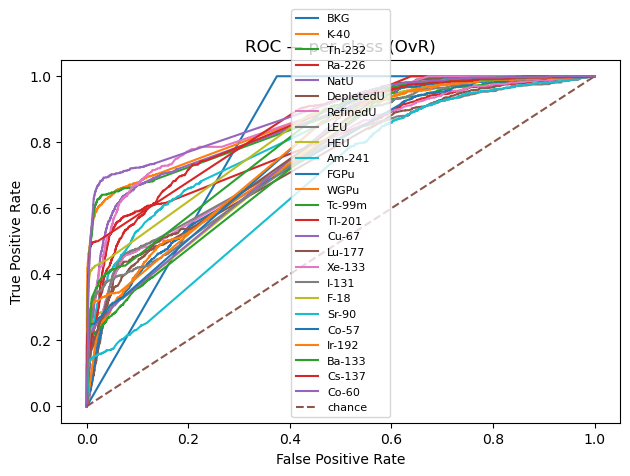

In [90]:
# Recreates block 20 and saves figures.
import numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from datetime import datetime

def _softmax(z):
    z = np.atleast_2d(z); z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z); return e / e.sum(axis=1, keepdims=True)

# --- Probabilities on test set
Z = ACTIVE_MODEL.decision_function(Xte_active)  # (N, C)
P = _softmax(Z)

classes_present = np.unique(yte_active)
y_bin = label_binarize(yte_active, classes=classes_present)
P_sub = P[:, classes_present]

# --- Per-class ROC
fpr_dict, tpr_dict, auc_dict = {}, {}, {}
for j, c in enumerate(classes_present):
    fpr, tpr, _ = roc_curve(y_bin[:, j], P_sub[:, j])
    fpr_dict[c], tpr_dict[c] = fpr, tpr
    auc_dict[c] = auc(fpr, tpr)

# --- Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), P_sub.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# --- Macro-average
all_fpr = np.unique(np.concatenate([fpr_dict[c] for c in classes_present]))
mean_tpr = np.zeros_like(all_fpr)
for c in classes_present:
    mean_tpr += np.interp(all_fpr, fpr_dict[c], tpr_dict[c])
mean_tpr /= len(classes_present)
auc_macro = auc(all_fpr, mean_tpr)

# --- Ensure save directory
try:
    outdir = FIG_DIR  # from your block [27]
except NameError:
    run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
    outdir = Path("results") / run_id / "figures"
outdir.mkdir(parents=True, exist_ok=True)

# --- Plot A: micro & macro
fig = plt.figure()
plt.plot(fpr_micro, tpr_micro, label=f"micro-average (AUC={auc_micro:.3f})")
plt.plot(all_fpr, mean_tpr,  label=f"macro-average (AUC={auc_macro:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — micro & macro")
plt.legend(loc="lower right"); plt.tight_layout()
try:
    savefig("fig2_roc_micro_macro", fig=fig)  # uses your helper if defined
except NameError:
    fig.savefig(outdir / "fig2_roc_micro_macro.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot B: per-class ROC (optional; comment out if you only want Plot A)
fig = plt.figure()
for c in classes_present:
    plt.plot(fpr_dict[c], tpr_dict[c], label=names[c])
plt.plot([0,1],[0,1], linestyle="--", label="chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — per class (OvR)")
plt.legend(fontsize=8); plt.tight_layout()
try:
    savefig("fig2b_roc_per_class", fig=fig)
except NameError:
    fig.savefig(outdir / "fig2b_roc_per_class.png", dpi=300, bbox_inches="tight")
plt.show()


In [89]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_and_save_tp_fp_scatter(name="fig_tp_vs_fp_scatter", annotate_top=12):
    # Predict on test set
    Z = ACTIVE_MODEL.decision_function(Xte_active)
    y_pred = Z.argmax(axis=1)

    # Confusion matrix restricted to classes present in test
    labels = sorted(np.unique(yte_active))
    cm = confusion_matrix(yte_active, y_pred, labels=labels)

    # Per-class counts
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp        # predicted as class i but actually not i
    fn = cm.sum(axis=1) - tp        # actually class i but predicted not i
    support = cm.sum(axis=1)        # true count per class

    # Scatter: FP (x) vs TP (y); point size ~ support
    fig = plt.figure()
    ax = plt.gca()
    sizes = np.clip(20 + 2*support, 30, 300)    # keep sizes reasonable
    ax.scatter(fp, tp, s=sizes)
    ax.set_xlabel("False Positives (per class)")
    ax.set_ylabel("True Positives (per class)")
    ax.set_title("True vs False Positives — test set")
    ax.grid(True, linestyle=":")

    # Annotate the largest classes (by support) to reduce clutter
    idx = np.argsort(support)[::-1][:annotate_top]
    for k in idx:
        ax.annotate(names[labels[k]], (fp[k], tp[k]), xytext=(5,5), textcoords="offset points")

    plt.tight_layout()
    savefig(name, fig=fig)   # saves PNG/PDF/SVG in results/<RUN_ID>/figures
    plt.close(fig)

# Run:
plot_and_save_tp_fp_scatter()


Saved figure:
  results\20250914-235159\figures\fig_tp_vs_fp_scatter.png
  results\20250914-235159\figures\fig_tp_vs_fp_scatter.pdf
  results\20250914-235159\figures\fig_tp_vs_fp_scatter.svg


In [77]:
#Save-table helper (DataFrame → CSV/XLSX/LaTeX)
import pandas as pd

def savetab(df, name, folder=TAB_DIR, formats=("csv","xlsx","tex"), index=False, floatfmt="%.3f"):
    """
    Save a DataFrame to results/tables in selected formats.
    - CSV always works.
    - XLSX requires 'openpyxl' or 'xlsxwriter' (skips if missing).
    - TEX writes a simple LaTeX table (escape=True).
    """
    folder.mkdir(parents=True, exist_ok=True)
    stem = str(name).strip().replace(" ", "_").replace("/", "-")
    paths = []

    if "csv" in formats:
        p = folder / f"{stem}.csv"
        df.to_csv(p, index=index)
        paths.append(p)

    if "xlsx" in formats:
        p = folder / f"{stem}.xlsx"
        try:
            df.to_excel(p, index=index)
            paths.append(p)
        except Exception as e:
            print("XLSX export skipped:", e)

    if "tex" in formats:
        p = folder / f"{stem}.tex"
        try:
            tex = df.to_latex(index=index, float_format=(lambda x: floatfmt % x), escape=True)
        except TypeError:
            tex = df.to_latex(index=index, escape=True)
        p.write_text(tex, encoding="utf-8")
        paths.append(p)

    print("Saved table:", *map(str, paths), sep="\n  ")
    return [str(p) for p in paths]


In [78]:
# Saving the metrics and all bundle artifacts (model, labels, JSON)


import json, shutil
from pathlib import Path

def savemetrics(metrics_dict, name="metrics.json", folder=RESULTS_DIR):
    folder.mkdir(parents=True, exist_ok=True)
    p = folder / name
    with open(p, "w", encoding="utf-8") as f:
        json.dump(metrics_dict, f, indent=2)
    print("Saved metrics:", p.resolve())
    return str(p)

def save_artifacts(paths_or_pairs, folder=ARTIFACT_DIR):
    """
    Copy files into artifacts folder.
    - paths_or_pairs can be [path_str, ...] or [(src, dst_name), ...]
    """
    folder.mkdir(parents=True, exist_ok=True)
    saved = []
    for item in paths_or_pairs:
        if isinstance(item, (list, tuple)) and len(item) == 2:
            src, dst_name = Path(item[0]), str(item[1])
            dst = folder / dst_name
        else:
            src = Path(item); dst = folder / src.name
        if src.exists():
            shutil.copy2(src, dst)
            saved.append(dst)
    print("Saved artifacts:", *map(str, saved), sep="\n  ")
    return [str(p) for p in saved]


In [82]:
# Re-run [27] and [28] first to (re)define RESULTS_DIR/FIG_DIR and savefig()

from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR.mkdir(parents=True, exist_ok=True)
print("Figures dir:", FIG_DIR.resolve())

# quick sanity plot → should appear in results/<RUN_ID>/figures as 3 files
plt.figure()
plt.plot([0,1],[0,1])
plt.title("Sanity plot")
savefig("zz_sanity_plot")
plt.close()


Figures dir: C:\Users\Tamirepi\Documents\isotope_ID\results\20250914-235159\figures
Saved figure:
  results\20250914-235159\figures\zz_sanity_plot.png
  results\20250914-235159\figures\zz_sanity_plot.pdf
  results\20250914-235159\figures\zz_sanity_plot.svg


In [84]:
# If you just ran plotting cells without saving, try this immediately after:
import matplotlib.pyplot as plt

def save_all_open(prefix="fig"):
    nums = plt.get_fignums()
    if not nums:
        print("No open figures to save.")
        raise SystemExit
    for k, num in enumerate(nums, 1):
        fig = plt.figure(num)
        savefig(f"{prefix}_{k}", fig=fig)
        plt.close(fig)
    print("Saved all open figures.")

# Usage (optional rescue): save_all_open("batch_export")


In [85]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_and_save_roc(name_micro_macro="fig2_roc_micro_macro",
                      name_per_class="fig2b_roc_per_class"):
    Z = ACTIVE_MODEL.decision_function(Xte_active)
    def _softmax(z):
        z = np.atleast_2d(z); z = z - z.max(axis=1, keepdims=True)
        e = np.exp(z); return e / e.sum(axis=1, keepdims=True)
    P = _softmax(Z)

    classes_present = np.unique(yte_active)
    y_bin = label_binarize(yte_active, classes=classes_present)
    P_sub = P[:, classes_present]

    fpr_dict, tpr_dict, auc_dict = {}, {}, {}
    for j, c in enumerate(classes_present):
        fpr, tpr, _ = roc_curve(y_bin[:, j], P_sub[:, j])
        fpr_dict[c], tpr_dict[c] = fpr, tpr
        auc_dict[c] = auc(fpr, tpr)

    # micro
    fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), P_sub.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)

    # macro
    all_fpr = np.unique(np.concatenate([fpr_dict[c] for c in classes_present]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in classes_present:
        mean_tpr += np.interp(all_fpr, fpr_dict[c], tpr_dict[c])
    mean_tpr /= len(classes_present)
    auc_macro = auc(all_fpr, mean_tpr)

    # Figure A: micro & macro
    fig = plt.figure()
    plt.plot(fpr_micro, tpr_micro, label=f"micro (AUC={auc_micro:.3f})")
    plt.plot(all_fpr, mean_tpr,  label=f"macro (AUC={auc_macro:.3f})")
    plt.plot([0,1],[0,1], linestyle="--", label="chance")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — micro & macro")
    plt.legend(loc="lower right"); plt.tight_layout()
    savefig(name_micro_macro, fig=fig); plt.close(fig)

    # Figure B: per-class
    fig = plt.figure()
    for c in classes_present:
        plt.plot(fpr_dict[c], tpr_dict[c], label=names[c])
    plt.plot([0,1],[0,1], linestyle="--", label="chance")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — per class (OvR)")
    plt.legend(fontsize=8); plt.tight_layout()
    savefig(name_per_class, fig=fig); plt.close(fig)

# Run:
plot_and_save_roc()


Saved figure:
  results\20250914-235159\figures\fig2_roc_micro_macro.png
  results\20250914-235159\figures\fig2_roc_micro_macro.pdf
  results\20250914-235159\figures\fig2_roc_micro_macro.svg
Saved figure:
  results\20250914-235159\figures\fig2b_roc_per_class.png
  results\20250914-235159\figures\fig2b_roc_per_class.pdf
  results\20250914-235159\figures\fig2b_roc_per_class.svg


In [86]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_and_save_confusion(name="fig1_confusion_matrix"):
    labels = sorted(np.unique(yte_active))
    pred = ACTIVE_MODEL.decision_function(Xte_active).argmax(axis=1)
    cm = confusion_matrix(yte_active, pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=[names[i] for i in labels])
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap="viridis", colorbar=False, values_format="d")
    plt.title(f"Confusion Matrix — {('S–B' if FEATURE_MODE=='sb' else 'L1+log')}")
    plt.tight_layout()
    savefig(name, fig=fig)
    plt.close(fig)

# Run:
plot_and_save_confusion()


Saved figure:
  results\20250914-235159\figures\fig1_confusion_matrix.png
  results\20250914-235159\figures\fig1_confusion_matrix.pdf
  results\20250914-235159\figures\fig1_confusion_matrix.svg


In [79]:
#Examples: save confusion matrix, per-class report, and figures
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix as a table
labels = sorted(np.unique(yte_active))
cm = confusion_matrix(yte_active, (ACTIVE_MODEL.decision_function(Xte_active)).argmax(axis=1), labels=labels)
cm_df = pd.DataFrame(cm,
    index=[names[i] for i in labels],
    columns=[names[i] for i in labels]
)
savetab(cm_df, "confusion_matrix", formats=("csv","xlsx","tex"))

# Per-class precision/recall/F1 as a table
rep = classification_report(
    yte_active,
    (ACTIVE_MODEL.decision_function(Xte_active)).argmax(axis=1),
    target_names=[names[i] for i in labels],
    output_dict=True,
    zero_division=0
)
rep_df = pd.DataFrame(rep).transpose()
savetab(rep_df, "per_class_metrics", formats=("csv","xlsx","tex"))

# Save any current figure (call this right after you plot):
# savefig("roc_micro_macro")
# savefig("selective_accuracy_vs_coverage")
# savefig("peaks_vs_prediction_idx0")


Saved table:
  results\20250914-235159\tables\confusion_matrix.csv
  results\20250914-235159\tables\confusion_matrix.xlsx
  results\20250914-235159\tables\confusion_matrix.tex
Saved table:
  results\20250914-235159\tables\per_class_metrics.csv
  results\20250914-235159\tables\per_class_metrics.xlsx
  results\20250914-235159\tables\per_class_metrics.tex


['results\\20250914-235159\\tables\\per_class_metrics.csv',
 'results\\20250914-235159\\tables\\per_class_metrics.xlsx',
 'results\\20250914-235159\\tables\\per_class_metrics.tex']

In [87]:
import numpy as np, matplotlib.pyplot as plt

def plot_and_save_selective_curve(name="fig3_selective_accuracy_vs_coverage"):
    Zte = ACTIVE_MODEL.decision_function(Xte_active)
    def _softmax(z):
        z = np.atleast_2d(z); z = z - z.max(axis=1, keepdims=True)
        e = np.exp(z); return e / e.sum(axis=1, keepdims=True)
    Pte = _softmax(Zte)
    tp   = Pte.max(axis=1)
    pred = Pte.argmax(axis=1)

    taus = np.linspace(0.4, 0.98, 60)
    cov, sel = [], []
    for t in taus:
        m = tp >= t
        cov.append(m.mean())
        sel.append((pred[m]==yte_active[m]).mean() if m.any() else np.nan)

    fig = plt.figure()
    plt.plot(taus, cov, label="coverage")
    plt.plot(taus, sel, label="selective accuracy")
    try:
        tau_line = float(TAU)
        plt.axvline(tau_line, linestyle="--", label=f"τ={tau_line:.2f}")
    except Exception:
        pass
    plt.xlabel("Threshold τ"); plt.ylabel("Value")
    plt.title("Selective accuracy vs coverage (test)")
    plt.legend(); plt.tight_layout()
    savefig(name, fig=fig); plt.close(fig)

# Run:
plot_and_save_selective_curve()


Saved figure:
  results\20250914-235159\figures\fig3_selective_accuracy_vs_coverage.png
  results\20250914-235159\figures\fig3_selective_accuracy_vs_coverage.pdf
  results\20250914-235159\figures\fig3_selective_accuracy_vs_coverage.svg


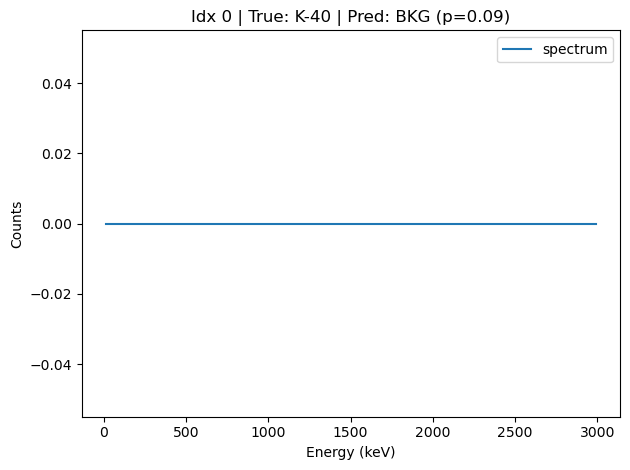

No comparable reference lines (either unknown isotope mapping or no energy axis).
Saved figure:
  results\20250914-235159\figures\fig4_peaks_vs_prediction_idx0.png
  results\20250914-235159\figures\fig4_peaks_vs_prediction_idx0.pdf
  results\20250914-235159\figures\fig4_peaks_vs_prediction_idx0.svg


In [88]:
# If you already defined plot_peaks_vs_prediction earlier:
import matplotlib.pyplot as plt

def plot_peaks_and_save(i=0, name=None, **kwargs):
    # Reuse your existing plotter
    plot_peaks_vs_prediction(i=i, **kwargs)
    if name is None:
        name = f"fig4_peaks_vs_prediction_idx{i}"
    savefig(name)
    plt.close()

# Run:
plot_peaks_and_save(i=0, peak_frac=0.10, tol_keV=35.0)


In [80]:
# Save the final model bundle + labels into artifacts
save_artifacts(["isoid_model.joblib", "isoid_labels.json"])

# If you have a metrics dict from cell [24], save it:
try:
    savemetrics(summary, name="metrics.json")
except NameError:
    pass


Saved artifacts:
  results\20250914-235159\artifacts\isoid_model.joblib
  results\20250914-235159\artifacts\isoid_labels.json
Saved metrics: C:\Users\Tamirepi\Documents\isotope_ID\results\20250914-235159\metrics.json
